In [20]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
edgelist=[]

with open(r"C:\Users\rishi\ml_projects\SBGNN\senate1to10_cikm2019_balance_in_signed_bipartite_networks.txt") as f:
        for ind, line in enumerate(f):
            if ind == 0: 
                na,nb,ns=map(int, line.split('\t'))
                set_b=[f"set_b_{i}" for i in range(0,nb)]
                set_a=[f"set_a_{i}" for i in range(0,na)]
                continue
            a, b, s = map(int, line.split('\t'))
            if s==1:
                edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'+1' }))
            else:
                 edgelist.append((f"set_a_{a}",f"set_b_{b}",{'sign' :'-1' }))

B = nx.Graph()
B.add_nodes_from(set_a, bipartite=0)
B.add_nodes_from(set_b, bipartite=1)
B.add_edges_from(edgelist)

In [22]:
colors = ['yellow' for _ in set_a] + ['green' for _ in set_b]
print(len(colors))
print(len(set_a))
print(len(set_b))
node_list=["bill_100","sen_100"]
# Draw the graph
num_nodes = B.number_of_nodes()

print("Number of nodes in the graph:", num_nodes)

1201
145
1056
Number of nodes in the graph: 1201


In [23]:
edge_colors = []
for u, v, attrs in B.edges(data=True):
    if attrs['sign'] == '+1':
        edge_colors.append('blue')   # Positive sign color
    else:
        edge_colors.append('red') 

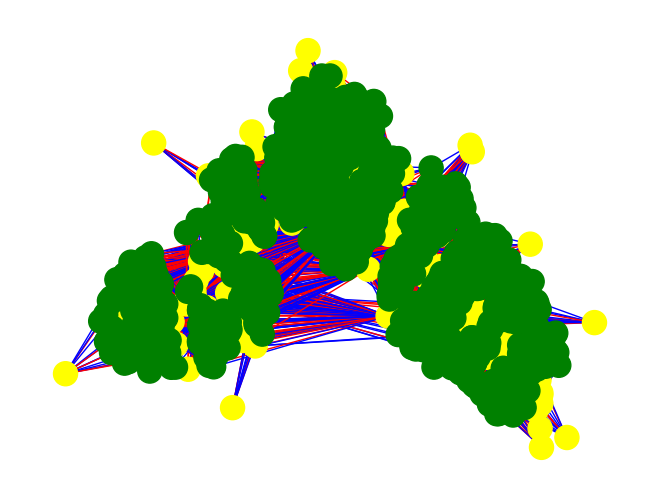

In [24]:
nx.draw(B, with_labels=False,node_color=colors,edge_color=edge_colors)
plt.show()

In [25]:
print(B.nodes(data=True))

[('set_a_0', {'bipartite': 0}), ('set_a_1', {'bipartite': 0}), ('set_a_2', {'bipartite': 0}), ('set_a_3', {'bipartite': 0}), ('set_a_4', {'bipartite': 0}), ('set_a_5', {'bipartite': 0}), ('set_a_6', {'bipartite': 0}), ('set_a_7', {'bipartite': 0}), ('set_a_8', {'bipartite': 0}), ('set_a_9', {'bipartite': 0}), ('set_a_10', {'bipartite': 0}), ('set_a_11', {'bipartite': 0}), ('set_a_12', {'bipartite': 0}), ('set_a_13', {'bipartite': 0}), ('set_a_14', {'bipartite': 0}), ('set_a_15', {'bipartite': 0}), ('set_a_16', {'bipartite': 0}), ('set_a_17', {'bipartite': 0}), ('set_a_18', {'bipartite': 0}), ('set_a_19', {'bipartite': 0}), ('set_a_20', {'bipartite': 0}), ('set_a_21', {'bipartite': 0}), ('set_a_22', {'bipartite': 0}), ('set_a_23', {'bipartite': 0}), ('set_a_24', {'bipartite': 0}), ('set_a_25', {'bipartite': 0}), ('set_a_26', {'bipartite': 0}), ('set_a_27', {'bipartite': 0}), ('set_a_28', {'bipartite': 0}), ('set_a_29', {'bipartite': 0}), ('set_a_30', {'bipartite': 0}), ('set_a_31', {'bi

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_prob=0.4):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)   # Fully connected layer
        self.dropout = nn.Dropout(p=dropout_prob)    # Dropout layer
        self.output_layer = nn.Linear(output_dim, output_dim)  # Output layer

    def forward(self, x):
        x = F.relu(self.fc1(x))    # Apply ReLU activation to the fully connected layer
        x = self.dropout(x)        # Apply dropout to the output of the fully connected layer
        x = self.output_layer(x)   # Output layer, no activation function
        return x

In [44]:
class SBGNN(nn.Module):
    def __init__(self, graph, emb_dim_a=32, emb_dim_b=32):
        super(SBGNN, self).__init__()

        self.graph = graph
        self.set_a = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 0]
        self.set_b = [n for n, d in self.graph.nodes(data=True) if d['bipartite'] == 1]
        self.emb_dim_a = emb_dim_a
        self.emb_dim_b = emb_dim_b

        # Initialize ModuleDict for features_a and features_b
        self.features_a = nn.ModuleDict({str(node): nn.Embedding(1, self.emb_dim_a) for node in self.set_a})
        self.features_b = nn.ModuleDict({str(node): nn.Embedding(1, self.emb_dim_b) for node in self.set_b})

        self.weight_a_b = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_a_u = nn.Parameter(torch.randn(self.emb_dim_a, self.emb_dim_a))
        self.weight_b_b = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))
        self.weight_b_u = nn.Parameter(torch.randn(self.emb_dim_b, self.emb_dim_b))

        self.mlp_a = MLP(3 * self.emb_dim_a, self.emb_dim_a)
        self.mlp_b = MLP(3 * self.emb_dim_b, self.emb_dim_b)

    def message_passing(self, iterations=1):
        for i in range(iterations):
            new_features_a = {}
            new_features_b = {}

            for node in self.set_a:
                new_features_a_b = torch.zeros(self.emb_dim_a)
                new_features_a_u = torch.zeros(self.emb_dim_a)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                        sign = self.graph.edges[node, neighbor]['sign']
                        if sign == '+1':
                            new_features_a_b += self.features_b[str(neighbor)].weight.squeeze(0)
                            count_b += 1
                        else:
                            new_features_a_u += self.features_b[str(neighbor)].weight.squeeze(0)
                            count_u += 1

                if count_b > 0:
                    new_features_a_b /= count_b
                    new_features_a_b = torch.matmul(new_features_a_b, self.weight_a_b)

                if count_u > 0:
                    new_features_a_u /= count_u
                    new_features_a_u = torch.matmul(new_features_a_u, self.weight_a_u)

                new_features_a[str(node)] = torch.cat((new_features_a_b, new_features_a_u, self.features_a[str(node)].weight.squeeze(0)), dim=0)
                new_features_a[str(node)] = self.mlp_a(new_features_a[str(node)])

            for node in self.set_b:
                new_features_b_b = torch.zeros(self.emb_dim_b)
                new_features_b_u = torch.zeros(self.emb_dim_b)
                count_b = 0
                count_u = 0

                for neighbor in self.graph.neighbors(node):
                        sign = self.graph.edges[node, neighbor]['sign']
                        if sign == '+1':
                            new_features_b_b += self.features_a[str(neighbor)].weight.squeeze(0)
                            count_b += 1
                        else:
                            new_features_b_u += self.features_a[str(neighbor)].weight.squeeze(0)
                            count_u += 1

                if count_b > 0:
                    new_features_b_b /= count_b
                    new_features_b_b = torch.matmul(new_features_b_b, self.weight_b_b)

                if count_u > 0:
                    new_features_b_u /= count_u
                    new_features_b_u = torch.matmul(new_features_b_u, self.weight_b_u)

                new_features_b[str(node)] = torch.cat((new_features_b_b, new_features_b_u, self.features_b[str(node)].weight.squeeze(0)), dim=0)
                new_features_b[str(node)] = self.mlp_b(new_features_b[str(node)])

            # Update ModuleDicts
            for node in self.set_a:
                self.features_a[str(node)].weight = nn.Parameter(new_features_a[str(node)].unsqueeze(0))

            for node in self.set_b:
                self.features_b[str(node)].weight = nn.Parameter(new_features_b[str(node)].unsqueeze(0))

    


In [45]:
sbgnn = SBGNN(B)
print(sbgnn.features_a["set_a_0"].weight.squeeze(0))
sbgnn.message_passing(iterations=4)


tensor([-3.0994, -0.2078, -1.4815, -0.4390, -0.4774,  1.3406, -0.5307, -0.3709,
         0.0690,  0.6322, -0.3132, -0.8590, -1.0956,  0.3690, -0.6786, -1.1613,
        -0.8002, -0.4024,  0.2643,  0.2869, -1.5007,  0.4224, -2.0031,  0.9625,
         0.1140,  0.5054, -0.0888, -1.0983, -1.5850,  1.4598,  0.4275, -0.9457],
       grad_fn=<SqueezeBackward1>)


In [53]:
print(sbgnn.features_a["set_a_0"].weight.squeeze(0))

tensor([-1.1470, -0.4363, -1.2743,  0.6847, -0.3548, -0.0767, -0.9657,  0.1886,
         0.3289, -0.6179, -1.2589, -1.0360, -1.1008, -0.3567, -0.1051,  0.8166,
        -1.0136, -0.3454,  1.5804,  1.1179,  0.4843, -0.1276, -0.7398, -0.9548,
         0.8641,  0.1121, -0.5346,  1.0068, -0.4851, -0.3684,  0.2638,  0.5762],
       grad_fn=<SqueezeBackward1>)


In [77]:
C_a=torch.zeros(1,32)
C_b=torch.ones(1,32)
list_a=[C_a,C_b]
stacked_tensor = torch.stack(list_a, dim=1).squeeze(0)
print(stacked_tensor)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [86]:
class Softmax(nn.Module):
    def __init__(self, input_dim, cluster_number):
        super(Softmax, self).__init__()
        self.fc = nn.Linear(input_dim, cluster_number)  # Fully connected layer

    def forward(self, x):
        x = self.fc(x)         # Apply the fully connected layer
        x = F.softmax(x, dim=0)  # Apply softmax to the output
        return x


In [87]:
class Community(nn.Module):
    def __init__(self, sbgnn, cluster_number):
        super(Community, self).__init__()
        
        self.sbgnn=sbgnn
        self.cluster_number=cluster_number
        self.emb_dim_a=self.sbgnn.emb_dim_a
        self.emb_dim_b=self.sbgnn.emb_dim_b

        self.Softmax_a=Softmax(self.emb_dim_a,self.cluster_number)
        self.Softmax_b=Softmax(self.emb_dim_b,self.cluster_number)


    def build_communities(self):
        self.list_a=[]
        self.list_b=[]
        
        for node in sbgnn.set_a:
            new_tensor=sbgnn.features_a[str(node)].weight.squeeze(0)
            new_tensor=self.Softmax_a(new_tensor)
            self.list_a.append(new_tensor)
        
        self.C_a=torch.stack(self.list_a,dim=1).squeeze(0)

        for node in sbgnn.set_b:
            new_tensor=sbgnn.features_b[str(node)].weight.squeeze(0)
            new_tensor=self.Softmax_b(new_tensor)
            self.list_b.append(new_tensor)
        
        self.C_b=torch.stack(self.list_b,dim=1).squeeze(0)


In [88]:
comm=Community(sbgnn,5)
comm.build_communities()

In [89]:
class Modularity(nn.Module):
    def __init__(self, graph,community):
        super(Modularity, self).__init__()


        self.graph=graph
        self.adj=nx.adjacency_matrix(self.graph).todense()
        self.adj_tensor=torch.tensor(self.adj,dtype=torch.float32)
        self.community=community
        self.C_a=self.community.C_a
        self.C_b=self.community.C_b

In [90]:
inst=Modularity(B,comm)
print(inst.adj_tensor)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
